# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

O objetivo deste notebook é ilustrar 
- o uso do gradiente estocástico por mini-batchs
- utilizando as classes Dataset e DataLoater.

A apresentação da perda nos gráficos é um pouco diferente da usual, mostrando a perda de cada um dos vários minibatches dentro de cada época, de forma que as épocas são apresentadas com valores fracionários.

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Inicialização do histórico de treinamentos

In [2]:
d_batchsize = dict()

## Definição do tamanho do minibatch

In [22]:
batch_size = 50

## Carregamento e normalização dos dados do MNIST

In [23]:
dataset_dir = '/data/datasets/MNIST/'

dataset_train = torchvision.datasets.MNIST(dataset_dir, train=True, download=False,
                                           transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST(dataset_dir, train=False, download=False,
                                          transform=torchvision.transforms.ToTensor())

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(loader_train))
print('Número de minibatches de teste:     ', len(loader_test))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 1200
Número de minibatches de teste:      200

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  0.0 1.0
Tipo dos dados das imagens:          <class 'torch.FloatTensor'>
Tipo das classes das imagens:        <class 'torch.LongTensor'>


## Seleção dos dados do MNIST

Neste exemplo utilizaremos 500 amostras de treinamento e 100 amostras de teste.

In [24]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500

    dataset_train.train_data = dataset_train.train_data[:n_samples_train]
    dataset_train.train_labels = dataset_train.train_labels[:n_samples_train]

    dataset_test.test_data = dataset_test.test_data[:n_samples_test]
    dataset_test.test_labels = dataset_test.test_labels[:n_samples_test]

print('Número de minibatches de trenamento:', len(loader_train))
print('Número de minibatches de teste:     ', len(loader_test))
n_batches_train = len(loader_train)
total_samples = dataset_train.train_data.size(0)

Número de minibatches de trenamento: 20
Número de minibatches de teste:      10


## Treinamento

### Inicialização dos parâmetros

In [25]:
n_epochs = 100
learningRate = 0.5

# Cria uma operação linear com entrada de tamanho 28*28 e saída com 10 neurônios (classes)
# O objeto criado armazenará os pesos
model = torch.nn.Linear(28*28, 10)

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss(size_average=True)

# Nosso otomizador será SDG
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Laço de treinamento dos pesos

In [26]:
epochs = []
losses = []

total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # calcula a saída da operação linear
        outputs = model(inputs)

        # calcula a perda
        targets = Variable(y_train)
        loss = criterion(outputs, targets)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / total_samples)
        losses.append(loss.data[0])
    print('Época: {:d}/{:d}'.format(i,n_epochs-1), end='\r')

d_batchsize[batch_size] = (epochs, losses)

In [27]:
print('Final loss:', loss.data[0])

Final loss: 0.018596259877085686


## Visualizando gráfico de perda durante o treinamento

### Todo o treinamento, com a perda em cada minibatch

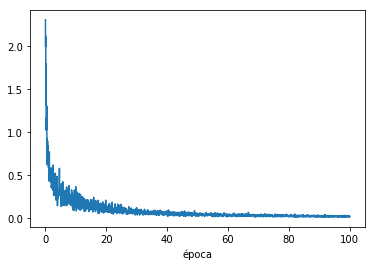

In [28]:
plt.plot(epochs, losses)
plt.xlabel('época')

### Perda dos primeiro 100 minibatches (5 épocas)

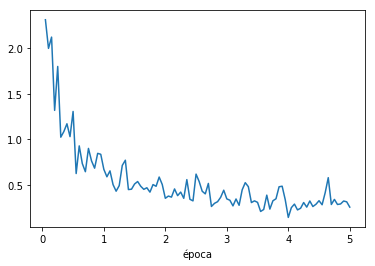

In [33]:
plt.plot(epochs[:5 * n_batches_train], losses[:5 * n_batches_train])
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

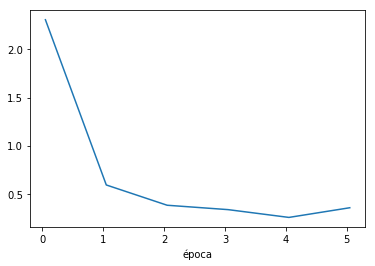

In [35]:
plt.plot(epochs[:5 * n_batches_train +1:n_batches_train], losses[:5 * n_batches_train+1:n_batches_train])
plt.xlabel('época')

## Avaliando a acurácia tanto no conjunto de treinamento como no conjunto de testes

In [54]:
def getAccuracy(model, input_data, targets):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    predicts = predicts.data.numpy()
    targets = targets.numpy()
    
    accuracy = (predicts == targets).mean()
    return accuracy

x_train, y_train = dataset_train.train_data, dataset_train.train_labels
x_train = x_train.float() / 255.
print('Training Accuracy:', getAccuracy(model, x_train.view(-1, 28*28), y_train))

x_test, y_test = dataset_test.test_data, dataset_test.test_labels
x_test = x_test.float() / 255.
print('Test Accuracy    :', getAccuracy(model, x_test.view(-1, 28*28), y_test))

Training Accuracy: 1.0
Test Accuracy    : 0.846


# Atividades

## Exercícios


1. Coloque um print no final de cada minibatch, no mesmo estilo do print do final de época.
2. Altere o tamanho de minibatch (batch_size) algumas vezes, refaça o treinamento, e compare no gráfico abaixo a queda da perda para cada tamanho de minibatch.

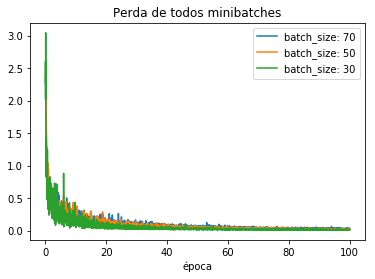

In [55]:
plt.figure()
plt.title('Perda de todos minibatches')
plt.xlabel('época')
for batchsize, (epochs, losses) in sorted(d_batchsize.items(), reverse=True):
    plt.plot(epochs, losses, label='batch_size: {}'.format(batchsize))
plt.legend()
plt.show()

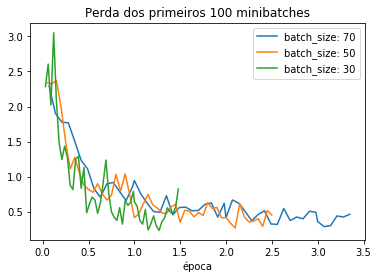

In [57]:
plt.figure()
plt.title('Perda dos primeiros 100 minibatches')
plt.xlabel('época')
for batchsize, (epochs, losses) in sorted(d_batchsize.items(), reverse=True):
    plt.plot(epochs[:50], losses[:50], label='batch_size: {}'.format(batchsize))
plt.legend()
plt.show()

## Perguntas

1. Qual é o tamanho do mini-batch?
2. Em uma época, quantos mini-batches existem?

## Conclusões sobre os experimentos deste notebook
